# 機器學習百日馬拉松期中專案 - Enron fraud dataset analysis

![](https://i.imgur.com/TCyQYiy.png)

## AGENDA
1. 專案摘要
1. 機器學習專案流程
2. 實作方法介紹
3. 成果展示
4. 結論

## 一、專案摘要

![](https://i.imgur.com/8AIQrF6.png)

安隆公司曾是一間能源公司，2001 年破產前是世界上最大的電力、天然氣及電信公司之一。擁有上千億資產的公司於 2002 年竟然在短短幾周內宣告破產，才揭露其財報在多年以來均是造假的醜聞。在本資料集中你將會扮演偵探的角色，透過高層經理人內部的 mail 來往的情報以及薪資、股票等財務特徵，訓練出一個機器學習模型來幫忙你找到可疑的詐欺犯罪者是誰! 我們已經先幫你找到幾位犯罪者 (Person-of-Interest, poi) 與清白的員工，請利用這些訓練資料來訓練屬於自己的詐欺犯機器學習模型吧!

[比賽網址](https://www.kaggle.com/competitions/2020-ml100marathon-midterm/leaderboard)

## 二、機器學習專案流程

#### 一、資料蒐集、定義目標:
- [x] 資料來源
- [x] 特徵說明
#### 二、資料前處理: 
- [x] EDA資料分布
- [x] 資料型態調整
- [x] 離群值處理
- [x] 特徵縮放/標準化
- [x] 分析變數關聯性

#### 三、特徵工程: 
- [x] 去除偏態
- [x] 特徵編碼
- [x] 特徵組合
- [x] 特徵選擇
- [x] 特徵評估

#### 四、設定評估準則: 
- [x] 決定評估指標

#### 五、建立模型: 
- [x] 定義模型
- [x] 評估模型
- [x] 最佳化模型

#### 六、調整參數: 
- [x] 超參數調整
- [x] 集成學習
#### 七、導入/部署

### 三、實作方法介紹

#### (1) 資料蒐集、定義目標

特徵說明:
有關財務的特徵: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (單位皆為美元)。更詳細的特徵說明請參考 enron61702insiderpay.pdf 的最後一頁(請至Data頁面參考該PDF檔)

有關 email 的特徵: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (除了 email_address，其餘皆為次數)

嫌疑人的標記，也就是我們常用的 y。POI label: [‘poi’] (boolean, represented as integer)

#### (2) 資料前處理 & (3)特徵工程

首先載入專案所需的所有套件:

In [29]:
#pip install imblearn

import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#處理資料偏態
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox

#訓練模型
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


#特徵工程
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler, OneHotEncoder,PowerTransformer

#演算法
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#處理資料不平衡
from imblearn.over_sampling import SMOTE, ADASYN

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)
plt.style.use('seaborn')
%matplotlib inline

讀取資料

In [151]:
train_data = pd.read_csv('./train_data.csv')
test_data = pd.read_csv('./test_features.csv')
data = pd.concat([train_data, test_data], axis = 0)

print(f'train shape: {train_data.shape}')
print(f'test shape: {test_data.shape}')
print(f'total shape: {data.shape}')

data.reset_index(inplace=True, drop=True)
data.head()

train shape: (113, 22)
test shape: (33, 21)
total shape: (146, 22)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


檢查 DataFrame 空缺值的狀態

In [152]:
def na_check(df_data, axis):
    data_na = (df_data.isnull().sum(axis = axis) / df_data.shape[axis]) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return missing_data

#查看一下每個變數(欄位)的遺失值狀況
print(na_check(data, 0))

                           Missing Ratio
loan_advances                  97.260274
director_fees                  88.356164
restricted_stock_deferred      87.671233
deferral_payments              73.287671
deferred_income                66.438356
long_term_incentive            54.794521
bonus                          43.835616
from_messages                  41.095890
from_poi_to_this_person        41.095890
from_this_person_to_poi        41.095890
shared_receipt_with_poi        41.095890
to_messages                    41.095890
other                          36.301370
expenses                       34.931507
salary                         34.931507
exercised_stock_options        30.136986
restricted_stock               24.657534
email_address                  23.972603
poi                            22.602740
total_payments                 14.383562
total_stock_value              13.698630


In [153]:
#看一下每筆資料的遺失值狀況
print(na_check(data, 1))

     Missing Ratio
107      90.909091
65       81.818182
17       81.818182
136      81.818182
79       81.818182
30       81.818182
98       77.272727
126      77.272727
94       77.272727
70       77.272727
100      77.272727
120      77.272727
62       77.272727
61       72.727273
35       72.727273
25       72.727273
38       72.727273
56       72.727273
105      72.727273
104      72.727273
74       72.727273
76       72.727273
140      72.727273
73       72.727273
92       68.181818
132      68.181818
44       68.181818
41       68.181818
84       68.181818
99       68.181818
50       63.636364
40       59.090909
5        59.090909
72       59.090909
55       59.090909
124      59.090909
137      59.090909
128      59.090909
130      59.090909
39       54.545455
125      54.545455
88       54.545455
6        54.545455
27       54.545455
18       54.545455
108      54.545455
109      54.545455
3        50.000000
71       50.000000
13       50.000000
24       50.000000
64       50.

去除掉一些遺失值狀況過於嚴重的資料

In [154]:
missing_values = na_check(data, 1) #以筆為單位去除
missing_indexs = missing_values[missing_values['Missing Ratio'] > 80].index
print(missing_indexs)

Int64Index([107, 65, 17, 136, 79, 30], dtype='int64')


112 之後的是測試資料，不能刪

In [155]:
missing_indexs = missing_indexs.drop(136)
print(missing_indexs)

Int64Index([107, 65, 17, 79, 30], dtype='int64')


看一下目前的資料欄位

In [156]:
data.columns

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'restricted_stock_deferred', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value'],
      dtype='object')

In [157]:
data.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.200000e+01,3.900000e+01,4.900000e+01,1.700000e+01,1.020000e+02,9.500000e+01,86.000000,86.000000,86.000000,4.000000e+00,6.600000e+01,9.300000e+01,1.100000e+02,1.800000e+01,9.500000e+01,86.000000,86.000000,1.250000e+02,1.260000e+02
mean,2.374235e+06,1.642674e+06,-1.140475e+06,1.668049e+05,5.987054e+06,1.087289e+05,608.790698,64.895349,41.232558,4.196250e+07,1.470361e+06,9.190650e+05,2.321741e+06,1.664106e+05,5.621943e+05,1176.465116,2073.860465,5.081526e+06,6.773957e+06
std,1.071333e+07,5.161930e+06,4.025406e+06,3.198914e+05,3.106201e+07,5.335348e+05,1841.033949,86.979244,100.073111,4.708321e+07,5.942759e+06,4.589253e+06,1.251828e+07,4.201494e+06,2.716369e+06,1178.317641,2582.700981,2.906172e+07,3.895777e+07
min,7.000000e+04,-1.025000e+05,-2.799289e+07,3.285000e+03,3.285000e+03,1.480000e+02,12.000000,0.000000,0.000000,4.000000e+05,6.922300e+04,2.000000e+00,-2.604490e+06,-7.576788e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.312500e+05,8.157300e+04,-6.948620e+05,9.878400e+04,5.278862e+05,2.261400e+04,22.750000,10.000000,1.000000,1.600000e+06,2.812500e+05,1.215000e+03,2.540180e+05,-3.896218e+05,2.118160e+05,249.750000,541.250000,3.944750e+05,4.945102e+05
50%,7.693750e+05,2.274490e+05,-1.597920e+05,1.085790e+05,1.310814e+06,4.695000e+04,41.000000,35.000000,8.000000,4.176250e+07,4.420350e+05,5.238200e+04,4.517400e+05,-1.469750e+05,2.599960e+05,740.500000,1211.000000,1.101393e+06,1.102872e+06
75%,1.200000e+06,1.002672e+06,-3.834600e+04,1.137840e+05,2.547724e+06,7.995250e+04,145.500000,72.250000,24.750000,8.212500e+07,9.386720e+05,3.620960e+05,1.002370e+06,-7.500975e+04,3.121170e+05,1888.250000,2634.750000,2.093263e+06,2.949847e+06
max,9.734362e+07,3.208340e+07,-8.330000e+02,1.398517e+06,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,8.392500e+07,4.852193e+07,4.266759e+07,1.303223e+08,1.545629e+07,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


分類一下特徵:

In [158]:
payment_columns = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                   'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments']
stock_columns = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
email_columns = ['email_address', 'from_messages', 'to_messages', 'from_poi_to_this_person', 
                 'from_this_person_to_poi', 'shared_receipt_with_poi']
print(f'payment: {len(payment_columns)}, stock: {len(stock_columns)}, email: {len(email_columns)}')

payment: 10, stock: 4, email: 6


整理以上共20個變數，另有name和poi兩個變數

先從payment相關變數開始處理:

In [159]:
df_payment = data[payment_columns]
df_payment

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
0,420636.0,1750000.0,1617011.0,-3504386.0,NaN,NaN,174839.0,46950.0,NaN,505050.0
1,1111258.0,5600000.0,1920000.0,NaN,NaN,NaN,22122.0,29336.0,NaN,8682716.0
2,211844.0,200000.0,NaN,-4167.0,NaN,NaN,1573324.0,22884.0,NaN,2003885.0
3,224305.0,800000.0,602671.0,NaN,NaN,NaN,907502.0,118134.0,NaN,2652612.0
4,240189.0,1250000.0,375304.0,-262500.0,NaN,NaN,486.0,35818.0,NaN,1639297.0
5,NaN,NaN,NaN,NaN,10259.0,NaN,2856.0,77978.0,NaN,91093.0
6,158403.0,NaN,NaN,NaN,NaN,NaN,147950.0,53947.0,NaN,360300.0
7,288542.0,1200000.0,NaN,-144062.0,27610.0,NaN,101740.0,16514.0,NaN,1490344.0
8,1072321.0,7000000.0,3600000.0,-300000.0,202911.0,81525000.0,10359729.0,99832.0,NaN,103559793.0
9,274975.0,600000.0,71023.0,NaN,NaN,NaN,200308.0,125978.0,NaN,1272284.0


初步觀察資料，先將遺失值統一填補為0:

In [160]:
df_payment = data[payment_columns]
df_payment = df_payment.fillna(0)

新增一些比率相關的特徵組合:

In [162]:
df_payment['bonus_payment_ratio'] = df_payment['bonus'] / df_payment['total_payments']
df_payment['salary_payment_ratio'] = df_payment['salary'] / df_payment['total_payments']
df_payment['bonus_salary_ratio'] = df_payment['bonus'] / df_payment['salary']

df_payment

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,bonus_payment_ratio,salary_payment_ratio,bonus_salary_ratio
0,420636.0,1750000.0,1617011.0,-3504386.0,0.0,0.0,174839.0,46950.0,0.0,505050.0,3.465003,0.832860,4.160367
1,1111258.0,5600000.0,1920000.0,0.0,0.0,0.0,22122.0,29336.0,0.0,8682716.0,0.644959,0.127985,5.039334
2,211844.0,200000.0,0.0,-4167.0,0.0,0.0,1573324.0,22884.0,0.0,2003885.0,0.099806,0.105717,0.944091
3,224305.0,800000.0,602671.0,0.0,0.0,0.0,907502.0,118134.0,0.0,2652612.0,0.301590,0.084560,3.566572
4,240189.0,1250000.0,375304.0,-262500.0,0.0,0.0,486.0,35818.0,0.0,1639297.0,0.762522,0.146520,5.204235
5,0.0,0.0,0.0,0.0,10259.0,0.0,2856.0,77978.0,0.0,91093.0,0.000000,0.000000,NaN
6,158403.0,0.0,0.0,0.0,0.0,0.0,147950.0,53947.0,0.0,360300.0,0.000000,0.439642,0.000000
7,288542.0,1200000.0,0.0,-144062.0,27610.0,0.0,101740.0,16514.0,0.0,1490344.0,0.805183,0.193608,4.158840
8,1072321.0,7000000.0,3600000.0,-300000.0,202911.0,81525000.0,10359729.0,99832.0,0.0,103559793.0,0.067594,0.010355,6.527896
9,274975.0,600000.0,71023.0,0.0,0.0,0.0,200308.0,125978.0,0.0,1272284.0,0.471593,0.216127,2.182017


因為有數值相除的計算，產生了許多NAN和inf，需再處理:

In [163]:
df_payment.fillna(0, inplace = True)
df_payment.replace(np.inf, 0, inplace = True)

In [164]:
df_payment.describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,bonus_payment_ratio,salary_payment_ratio,bonus_salary_ratio
count,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,146.000000
mean,3.658114e+05,1.333474e+06,6.646839e+05,-3.827622e+05,4.387965e+05,1.149658e+06,5.854318e+05,7.074827e+04,1.942249e+04,4.350622e+06,0.338515,0.149360,2.146357
std,2.203575e+06,8.094029e+06,4.046072e+06,2.378250e+06,2.741325e+06,9.649342e+06,3.682345e+06,4.327163e+05,1.190543e+05,2.693448e+07,0.578959,0.201734,3.701025
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.799289e+07,-1.025000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,-3.792600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.394475e+04,0.000000,0.000000,0.000000
50%,2.105960e+05,3.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.595000e+02,2.018200e+04,0.000000e+00,9.413595e+05,0.229269,0.095453,1.214860
75%,2.708505e+05,8.000000e+05,3.750648e+05,0.000000e+00,9.684500e+03,0.000000e+00,1.506065e+05,5.374075e+04,0.000000e+00,1.968287e+06,0.521874,0.214823,2.853164
max,2.670423e+07,9.734362e+07,4.852193e+07,0.000000e+00,3.208340e+07,8.392500e+07,4.266759e+07,5.235198e+06,1.398517e+06,3.098866e+08,5.196029,0.947950,24.532820


又有些欄位出現負數，先取絕對值修正:

In [165]:
df_payment['deferred_income'] = abs(df_payment['deferred_income'])
df_payment['deferral_payments'] = abs(df_payment['deferral_payments'])

評估調整完payment相關的資料了，把它跟name資料行合併起來:

In [166]:
pd.concat([data.name, df_payment], axis = 1)

,name,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,bonus_payment_ratio,salary_payment_ratio,bonus_salary_ratio
0,RICE KENNETH D,420636.0,1750000.0,1617011.0,3504386.0,0.0,0.0,174839.0,46950.0,0.0,505050.0,3.465003,0.832860,4.160367
1,SKILLING JEFFREY K,1111258.0,5600000.0,1920000.0,0.0,0.0,0.0,22122.0,29336.0,0.0,8682716.0,0.644959,0.127985,5.039334
2,SHELBY REX,211844.0,200000.0,0.0,4167.0,0.0,0.0,1573324.0,22884.0,0.0,2003885.0,0.099806,0.105717,0.944091
3,KOPPER MICHAEL J,224305.0,800000.0,602671.0,0.0,0.0,0.0,907502.0,118134.0,0.0,2652612.0,0.301590,0.084560,3.566572
4,CALGER CHRISTOPHER F,240189.0,1250000.0,375304.0,262500.0,0.0,0.0,486.0,35818.0,0.0,1639297.0,0.762522,0.146520,5.204235
5,HIRKO JOSEPH,0.0,0.0,0.0,0.0,10259.0,0.0,2856.0,77978.0,0.0,91093.0,0.000000,0.000000,0.000000
6,YEAGER F SCOTT,158403.0,0.0,0.0,0.0,0.0,0.0,147950.0,53947.0,0.0,360300.0,0.000000,0.439642,0.000000
7,COLWELL WESLEY,288542.0,1200000.0,0.0,144062.0,27610.0,0.0,101740.0,16514.0,0.0,1490344.0,0.805183,0.193608,4.158840
8,LAY KENNETH L,1072321.0,7000000.0,3600000.0,300000.0,202911.0,81525000.0,10359729.0,99832.0,0.0,103559793.0,0.067594,0.010355,6.527896
9,GLISAN JR BEN F,274975.0,600000.0,71023.0,0.0,0.0,0.0,200308.0,125978.0,0.0,1272284.0,0.471593,0.216127,2.182017


繪圖看一下資料點目前的分布狀況:

In [ ]:
train_num = train_data.shape[0]
color = ['r' if i == True else 'b' for i in train_data.poi] #繪製資料點散佈圖，poi資料點為紅色，反之為藍色

figure, (axes1, axes2, axes3, axes4) = plt.subplots(ncols = 4, nrows = 1, figsize = (24, 6))
axes1.scatter(df_payment['salary'][:train_num], df_payment['bonus'][:train_num], c = color)
axes1.set_xlabel('Salary ($)', fontsize = 15)
axes1.set_ylabel('Bonus ($)', fontsize = 15)
axes1.set_title('Original feature')

axes2.scatter(df_payment['salary_payment_ratio'][:train_num], df_payment['bonus_payment_ratio'][:train_num], c = color)
axes2.set_xlabel('Ratio of salary', fontsize = 15)
axes2.set_ylabel('Ratio of bonus', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df_payment['bonus_salary_ratio'][:train_num], df_payment['bonus_payment_ratio'][:train_num], c = color)
axes3.set_xlabel('Ratio of bonus to salary', fontsize = 15)
axes3.set_ylabel('Ratio of bonus', fontsize = 15)
axes3.set_title('New feature')

axes4.scatter(df_payment['bonus'][:train_num], df_payment['other'][:train_num], c = color)
axes4.set_xlabel('Bonus', fontsize = 15)
axes4.set_ylabel('Other', fontsize = 15)
axes4.set_title('New feature')

figure.tight_layout()
plt.show()

看起來資料偏態蠻明顯的，後續再處理，先接著處理stock相關變數

一樣先填補遺失值:

In [168]:
df_stock = data[stock_columns]
df_stock = df_stock.fillna(0)

In [169]:
df_stock

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
0,19794175.0,2748364.0,0.0,22542539.0
1,19250000.0,6843672.0,0.0,26093672.0
2,1624396.0,869220.0,0.0,2493616.0
3,0.0,985032.0,0.0,985032.0
4,0.0,126027.0,0.0,126027.0
5,30766064.0,0.0,0.0,30766064.0
6,8308552.0,3576206.0,0.0,11884758.0
7,0.0,698242.0,0.0,698242.0
8,34348384.0,14761694.0,0.0,49110078.0
9,384728.0,393818.0,0.0,778546.0


檢查股價總和:

In [170]:
for i in range(len(df_stock)):
    if np.sum(df_stock.iloc[i,:3]) != df_stock['total_stock_value'][i]:
        print(i,data.name[i])

50 BELFER ROBERT
139 BHATNAGAR SANJAY


修正資料:

In [171]:
# BELFER, ROBERT 資料有誤
df_stock.at[50, 'exercised_stock_options'] =  0
df_stock.at[50, 'restricted_stock'] =  44093
df_stock.at[50, 'restricted_stock_deferred'] =  -44093
df_stock.at[50, 'total_stock_value'] =  0
# BHATNAGAR SANJAY 資料有誤
df_stock.at[139, 'exercised_stock_options'] =  15456290.0
df_stock.at[139, 'restricted_stock'] =  2604490.0
df_stock.at[139, 'restricted_stock_deferred'] =  -2604490.0
df_stock.at[139, 'total_stock_value'] =  15456290.0

增加一些有關比率的特徵組合:

In [172]:
df_stock['exercised_total_ratio'] = df_stock['exercised_stock_options'] / df_stock['total_stock_value']
df_stock['restricted_total_ratio'] = df_stock['restricted_stock'] / df_stock['total_stock_value']
df_stock['exercised_restricted_ratio'] = df_stock['exercised_stock_options'] / df_stock['restricted_stock']
df_stock['restricted_stock_deferred'] = abs(df_stock['restricted_stock_deferred'])

#計算後修正
df_stock.replace(np.inf, 0, inplace = True)
df_stock = df_stock.fillna(0)

pd.concat([data.name, df_stock], axis = 1)

,name,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,exercised_total_ratio,restricted_total_ratio,exercised_restricted_ratio
0,RICE KENNETH D,19794175.0,2748364.0,0.0,22542539.0,0.878081,0.121919,7.202166
1,SKILLING JEFFREY K,19250000.0,6843672.0,0.0,26093672.0,0.737727,0.262273,2.812817
2,SHELBY REX,1624396.0,869220.0,0.0,2493616.0,0.651422,0.348578,1.868797
3,KOPPER MICHAEL J,0.0,985032.0,0.0,985032.0,0.000000,1.000000,0.000000
4,CALGER CHRISTOPHER F,0.0,126027.0,0.0,126027.0,0.000000,1.000000,0.000000
5,HIRKO JOSEPH,30766064.0,0.0,0.0,30766064.0,1.000000,0.000000,0.000000
6,YEAGER F SCOTT,8308552.0,3576206.0,0.0,11884758.0,0.699093,0.300907,2.323287
7,COLWELL WESLEY,0.0,698242.0,0.0,698242.0,0.000000,1.000000,0.000000
8,LAY KENNETH L,34348384.0,14761694.0,0.0,49110078.0,0.699416,0.300584,2.326859
9,GLISAN JR BEN F,384728.0,393818.0,0.0,778546.0,0.494162,0.505838,0.976918


繪圖觀察:

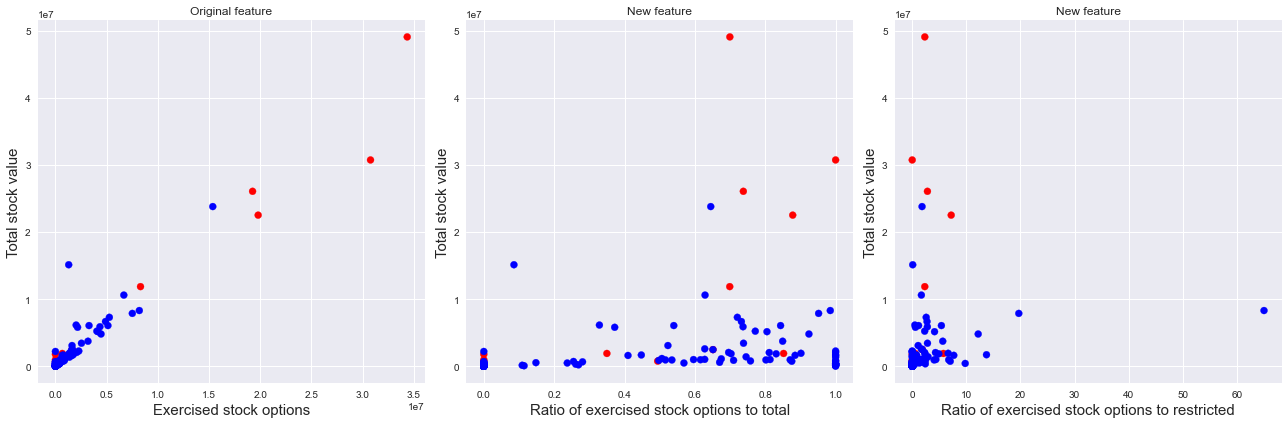

In [173]:
train_num = train_data.shape[0]
color = ['r' if i == True else 'b' for i in train_data.poi]  #繪製資料點散佈圖，poi資料點為紅色，反之為藍色

figure, (axes1, axes2, axes3) = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 6))
axes1.scatter(df_stock['exercised_stock_options'][:train_num], df_stock['total_stock_value'][:train_num], c = color)
axes1.set_xlabel('Exercised stock options', fontsize = 15)
axes1.set_ylabel('Total stock value', fontsize = 15)
axes1.set_title('Original feature')


axes2.scatter(df_stock['exercised_total_ratio'][:train_num], df_stock['total_stock_value'][:train_num], c = color)
axes2.set_xlabel('Ratio of exercised stock options to total', fontsize = 15)
axes2.set_ylabel('Total stock value', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df_stock['exercised_restricted_ratio'][:train_num], df_stock['total_stock_value'][:train_num], c = color)
axes3.set_xlabel('Ratio of exercised stock options to restricted', fontsize = 15)
axes3.set_ylabel('Total stock value', fontsize = 15)
axes3.set_title('New feature')

figure.tight_layout()
plt.show()

再來處理email相關變數:

In [174]:
df_email = data[email_columns]
df_email = df_email.fillna(0)

In [175]:
#新增變數組合
df_email['from_poi_ratio'] = df_email['from_poi_to_this_person'] / df_email['to_messages'] # 收信
df_email['to_poi_ratio'] = df_email['from_this_person_to_poi'] / df_email['from_messages'] # 寄信 
df_email['poi_interact_ratio'] = (df_email['from_this_person_to_poi'] + df_email['from_poi_to_this_person']) \
                               / (df_email['from_messages'] + df_email['to_messages']) #收&寄信
df_email['poi_receipt_ratio'] = df_email['shared_receipt_with_poi'] / df_email['to_messages'] 

#計算後修正
df_email = df_email.fillna(0)
df_email.replace(np.inf, 0, inplace = True)

pd.concat([data.name, df_email], axis = 1)

,name,email_address,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio
0,RICE KENNETH D,ken.rice@enron.com,18.0,905.0,42.0,4.0,864.0,0.046409,0.222222,0.049837,0.954696
1,SKILLING JEFFREY K,jeff.skilling@enron.com,108.0,3627.0,88.0,30.0,2042.0,0.024262,0.277778,0.031593,0.563000
2,SHELBY REX,rex.shelby@enron.com,39.0,225.0,13.0,14.0,91.0,0.057778,0.358974,0.102273,0.404444
3,KOPPER MICHAEL J,michael.kopper@enron.com,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,CALGER CHRISTOPHER F,christopher.calger@enron.com,144.0,2598.0,199.0,25.0,2188.0,0.076597,0.173611,0.081692,0.842186
5,HIRKO JOSEPH,joe.hirko@enron.com,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,YEAGER F SCOTT,scott.yeager@enron.com,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7,COLWELL WESLEY,wes.colwell@enron.com,40.0,1758.0,240.0,11.0,1132.0,0.136519,0.275000,0.139600,0.643914
8,LAY KENNETH L,kenneth.lay@enron.com,36.0,4273.0,123.0,16.0,2411.0,0.028785,0.444444,0.032258,0.564241
9,GLISAN JR BEN F,ben.glisan@enron.com,16.0,873.0,52.0,6.0,874.0,0.059565,0.375000,0.065242,1.001145


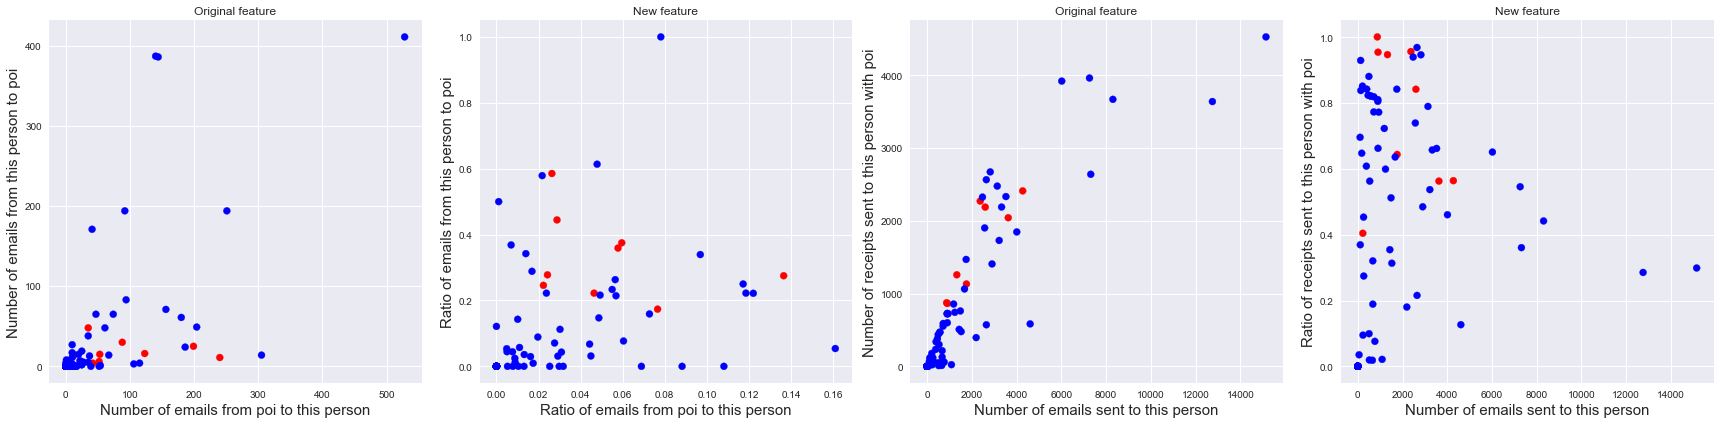

In [176]:
#繪圖

train_num = train_data.shape[0]
color = ['r' if i == True else 'b' for i in train_data.poi]  #繪製資料點散佈圖，poi資料點為紅色，反之為藍色

figure, (axes1, axes2, axes3, axes4) = plt.subplots(ncols = 4, nrows = 1, figsize = (24, 6))
axes1.scatter(df_email['from_poi_to_this_person'][:train_num], df_email['from_this_person_to_poi'][:train_num], c = color)
axes1.set_xlabel('Number of emails from poi to this person', fontsize = 15)
axes1.set_ylabel('Number of emails from this person to poi', fontsize = 15)
axes1.set_title('Original feature')


axes2.scatter(df_email['from_poi_ratio'][:train_num], df_email['to_poi_ratio'][:train_num], c = color)
axes2.set_xlabel('Ratio of emails from poi to this person', fontsize = 15)
axes2.set_ylabel('Ratio of emails from this person to poi', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df_email['to_messages'][:train_num], df_email['shared_receipt_with_poi'][:train_num], c = color)
axes3.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes3.set_ylabel('Number of receipts sent to this person with poi', fontsize = 15)
axes3.set_title('Original feature')

axes4.scatter(df_email['to_messages'][:train_num], df_email['poi_receipt_ratio'][:train_num], c = color)
axes4.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes4.set_ylabel('Ratio of receipts sent to this person with poi', fontsize = 15)
axes4.set_title('New feature')

figure.tight_layout()
plt.show()

In [ ]:
至此資料初步整理完成，合併目前幾份資料:

In [177]:
df = pd.concat([data['name'], data['poi'], df_payment, df_stock, df_email], axis = 1)

#再新增特徵組合
df['total_value'] = df['total_payments'] + df['total_stock_value']

丟棄一些類別過多、沒有太多分析點的資料欄位:

In [178]:
df = df.drop('email_address', axis = 1)
df = df.drop('loan_advances' ,axis = 1)

df.columns

Index(['name', 'poi', 'salary', 'bonus', 'long_term_incentive',
       'deferred_income', 'deferral_payments', 'other', 'expenses',
       'director_fees', 'total_payments', 'bonus_payment_ratio',
       'salary_payment_ratio', 'bonus_salary_ratio', 'exercised_stock_options',
       'restricted_stock', 'restricted_stock_deferred', 'total_stock_value',
       'exercised_total_ratio', 'restricted_total_ratio',
       'exercised_restricted_ratio', 'from_messages', 'to_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi',
       'shared_receipt_with_poi', 'from_poi_ratio', 'to_poi_ratio',
       'poi_interact_ratio', 'poi_receipt_ratio', 'total_value'],
      dtype='object')

丟掉資料遺失比例過高的資料:

In [179]:
df = df.drop(missing_indexs, axis = 0) 

print(f'shape: {df.shape}') 
df.reset_index(inplace=True, drop=True)
df

shape: (141, 31)


,name,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,...,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio,total_value
0,RICE KENNETH D,True,420636.0,1750000.0,1617011.0,3504386.0,0.0,174839.0,46950.0,0.0,...,18.0,905.0,42.0,4.0,864.0,0.046409,0.222222,0.049837,0.954696,23047589.0
1,SKILLING JEFFREY K,True,1111258.0,5600000.0,1920000.0,0.0,0.0,22122.0,29336.0,0.0,...,108.0,3627.0,88.0,30.0,2042.0,0.024262,0.277778,0.031593,0.563000,34776388.0
2,SHELBY REX,True,211844.0,200000.0,0.0,4167.0,0.0,1573324.0,22884.0,0.0,...,39.0,225.0,13.0,14.0,91.0,0.057778,0.358974,0.102273,0.404444,4497501.0
3,KOPPER MICHAEL J,True,224305.0,800000.0,602671.0,0.0,0.0,907502.0,118134.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3637644.0
4,CALGER CHRISTOPHER F,True,240189.0,1250000.0,375304.0,262500.0,0.0,486.0,35818.0,0.0,...,144.0,2598.0,199.0,25.0,2188.0,0.076597,0.173611,0.081692,0.842186,1765324.0
5,HIRKO JOSEPH,True,0.0,0.0,0.0,0.0,10259.0,2856.0,77978.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,30857157.0
6,YEAGER F SCOTT,True,158403.0,0.0,0.0,0.0,0.0,147950.0,53947.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,12245058.0
7,COLWELL WESLEY,True,288542.0,1200000.0,0.0,144062.0,27610.0,101740.0,16514.0,0.0,...,40.0,1758.0,240.0,11.0,1132.0,0.136519,0.275000,0.139600,0.643914,2188586.0
8,LAY KENNETH L,True,1072321.0,7000000.0,3600000.0,300000.0,202911.0,10359729.0,99832.0,0.0,...,36.0,4273.0,123.0,16.0,2411.0,0.028785,0.444444,0.032258,0.564241,152669871.0
9,GLISAN JR BEN F,True,274975.0,600000.0,71023.0,0.0,0.0,200308.0,125978.0,0.0,...,16.0,873.0,52.0,6.0,874.0,0.059565,0.375000,0.065242,1.001145,2050830.0


接著處理離群值的問題:

In [180]:
# 將訓練、測試資料分開，避免誤刪
# 前108筆為訓練資料，後33筆為測試資料
df_train = df[:108]
df_test = df[108:]

In [181]:
# 找離群值
outliers = dict()

for feature in df_train.columns:
    if df_train[feature].dtypes == 'float':
        # 統計數續還是用全部的資料
        q25 = df[feature].quantile(0.25)
        q50 = df[feature].quantile(0.5)
        q75 = df[feature].quantile(0.75)
        IQR = q75 - q25
        
        for i in range(108):
            if df_train[feature][i] > q50 + 1.5 * IQR or df_train[feature][i] < q50 - 1.5 * IQR: #1.5倍IQR原則
                if df_train['name'][i] not in outliers:
                    outliers[df_train['name'][i]] = 1
                else:
                    outliers[df_train['name'][i]] += 1

In [182]:
df_outliers = pd.DataFrame(outliers.keys(), outliers.values()).reset_index().sort_values(by = 'index', ascending = False)
df_outliers.columns = ['number', 'name']  #重新命名dataframe的欄位
df_outliers

,number,name
1,16,LAY KENNETH L
6,14,LAVORATO JOHN J
7,14,WHALLEY LAWRENCE G
0,13,SKILLING JEFFREY K
3,10,RICE KENNETH D
19,10,HAEDICKE MARK E
4,9,ALLEN PHILLIP K
17,9,BAXTER JOHN C
72,9,REDMOND BRIAN L
18,9,BUY RICHARD B


把poi資料合併進來，經觀察發現poi是在訓練資料中的前13筆:

In [183]:
df_outliers['poi'] = [1 if df_outliers['name'].values[i] in df_train['name'].values[:13] else 0 for i in range(len(df_outliers))]
df_outliers

,number,name,poi
1,16,LAY KENNETH L,1
6,14,LAVORATO JOHN J,0
7,14,WHALLEY LAWRENCE G,0
0,13,SKILLING JEFFREY K,1
3,10,RICE KENNETH D,1
19,10,HAEDICKE MARK E,0
4,9,ALLEN PHILLIP K,0
17,9,BAXTER JOHN C,0
72,9,REDMOND BRIAN L,0
18,9,BUY RICHARD B,0


還不能確定這些離群值有無特殊原因，保守一點先不刪除資料

In [184]:
#重新把資料拼起來
df = pd.concat([df_train, df_test], axis = 0)
df.reset_index(inplace = True, drop = True)
print(df.shape) #訓練資料108筆，測試資料33筆

(141, 31)


接著處理資料偏態問題:

In [185]:
#針對數值欄位，計算資料偏態係數
numeric_features = df.dtypes[df.dtypes != "object"].index
skew_of_features = df[numeric_features].apply(lambda x: skew(x, nan_policy = 'omit')).sort_values(ascending=False)
print(skew_of_features)

salary                        11.611736
expenses                      11.559993
bonus                         11.355941
long_term_incentive           11.263692
total_stock_value             11.248650
restricted_stock              11.190452
exercised_stock_options       11.155782
total_value                   10.986797
director_fees                 10.696180
deferred_income               10.690471
deferral_payments             10.548799
other                         10.318781
total_payments                10.263353
restricted_stock_deferred      9.495379
exercised_restricted_ratio     7.559016
from_messages                  7.134684
bonus_payment_ratio            5.231796
from_this_person_to_poi        4.982116
bonus_salary_ratio             3.876951
to_messages                    3.401972
from_poi_to_this_person        3.201299
restricted_total_ratio         2.623429
from_poi_ratio                 2.334176
salary_payment_ratio           2.108221
to_poi_ratio                   2.011497


偏態係數超過0.9的部分進行後續調整:

In [186]:
high_skewness = skew_of_features[abs(skew_of_features.values) > 0.9]
skewed_features = high_skewness.index
print(skewed_features)

Index(['salary', 'expenses', 'bonus', 'long_term_incentive',
       'total_stock_value', 'restricted_stock', 'exercised_stock_options',
       'total_value', 'director_fees', 'deferred_income', 'deferral_payments',
       'other', 'total_payments', 'restricted_stock_deferred',
       'exercised_restricted_ratio', 'from_messages', 'bonus_payment_ratio',
       'from_this_person_to_poi', 'bonus_salary_ratio', 'to_messages',
       'from_poi_to_this_person', 'restricted_total_ratio', 'from_poi_ratio',
       'salary_payment_ratio', 'to_poi_ratio', 'poi_interact_ratio',
       'shared_receipt_with_poi'],
      dtype='object')


In [187]:
#透過套件函數修正偏態
for feature in skewed_features:
    df[feature] = boxcox1p(df[feature], boxcox_normmax(df[feature] + 1))

In [188]:
print(df.shape)
df # 去偏態後的資料

(141, 31)


,name,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,...,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio,total_value
0,RICE KENNETH D,True,79.346511,108.111616,93.678382,43.044619,0.000000,18.506068,41.426151,0.000000,...,2.862787,24.307600,5.459698,1.459576,24.388317,0.026817,0.121888,0.031262,0.954696,70.038155
1,SKILLING JEFFREY K,True,100.071415,141.740208,97.338992,0.000000,0.000000,14.201569,37.047491,0.000000,...,4.486343,39.551136,7.035553,2.798691,33.176215,0.017910,0.135074,0.023242,0.563000,74.633026
2,SHELBY REX,True,67.241547,64.682633,0.000000,14.415159,0.000000,23.776922,34.905151,0.000000,...,3.561322,14.500656,3.413064,2.301726,10.236286,0.029767,0.148783,0.043245,0.404444,54.199152
3,KOPPER MICHAEL J,True,68.179628,89.953941,75.048121,0.000000,0.000000,22.383857,51.396806,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.396702
4,CALGER CHRISTOPHER F,True,69.318728,99.913678,67.404821,29.209704,0.000000,7.652634,38.853103,0.000000,...,4.746443,35.249975,9.061392,2.682337,33.993499,0.033129,0.106707,0.039906,0.842186,46.643638
5,HIRKO JOSEPH,True,0.000000,0.000000,0.000000,0.000000,17.563403,10.483568,46.666253,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.269980
6,YEAGER F SCOTT,True,62.654720,0.000000,0.000000,0.000000,0.000000,18.136009,42.805398,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.472800
7,COLWELL WESLEY,True,72.461347,98.960586,0.000000,26.580542,20.969558,17.320968,32.257401,0.000000,...,3.584322,30.763186,9.573105,2.139795,26.890297,0.037544,0.134500,0.046815,0.643914,48.293142
8,LAY KENNETH L,True,99.226717,149.258528,111.937768,29.821316,29.279880,28.953195,49.429489,0.000000,...,3.488635,41.837511,7.828392,2.390621,35.173365,0.020163,0.158493,0.023589,0.564241,93.537332
9,GLISAN JR BEN F,True,71.623422,84.043490,45.902310,0.000000,0.000000,18.810473,52.166873,0.000000,...,2.757560,23.995158,5.890897,1.729742,24.490487,0.030158,0.150909,0.036108,1.001145,47.788918


看一下修正過偏態後的資料分布:

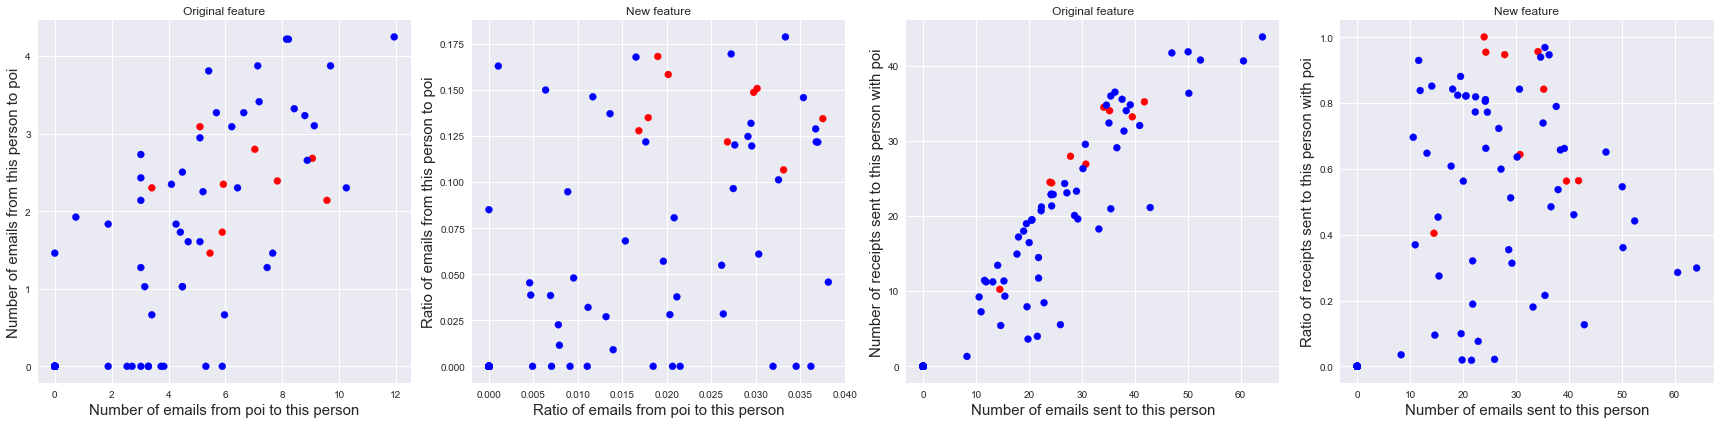

In [189]:
train_num = 108
color = ['r' if i == True else 'b' for i in df[:train_num]['poi']] #繪製資料點散佈圖，poi資料點為紅色，反之為藍色

figure, (axes1, axes2, axes3, axes4) = plt.subplots(ncols = 4, nrows = 1, figsize = (24, 6))
axes1.scatter(df['from_poi_to_this_person'][:train_num], df['from_this_person_to_poi'][:train_num], c = color)
axes1.set_xlabel('Number of emails from poi to this person', fontsize = 15)
axes1.set_ylabel('Number of emails from this person to poi', fontsize = 15)
axes1.set_title('Original feature')


axes2.scatter(df['from_poi_ratio'][:train_num], df['to_poi_ratio'][:train_num], c = color)
axes2.set_xlabel('Ratio of emails from poi to this person', fontsize = 15)
axes2.set_ylabel('Ratio of emails from this person to poi', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df['to_messages'][:train_num], df['shared_receipt_with_poi'][:train_num], c = color)
axes3.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes3.set_ylabel('Number of receipts sent to this person with poi', fontsize = 15)
axes3.set_title('Original feature')

axes4.scatter(df['to_messages'][:train_num], df['poi_receipt_ratio'][:train_num], c = color)
axes4.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes4.set_ylabel('Ratio of receipts sent to this person with poi', fontsize = 15)
axes4.set_title('New feature')

figure.tight_layout()
plt.show()

偏態的狀況很明顯有所改善

In [190]:
#再次確認目前的遺失值狀況，僅有poi
na_check(df, 0)

,Missing Ratio
poi,23.404255


開始訓練模型前的最後一段特徵工程:資料標準化

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        141 non-null    object 
 1   poi                         108 non-null    object 
 2   salary                      141 non-null    float64
 3   bonus                       141 non-null    float64
 4   long_term_incentive         141 non-null    float64
 5   deferred_income             141 non-null    float64
 6   deferral_payments           141 non-null    float64
 7   other                       141 non-null    float64
 8   expenses                    141 non-null    float64
 9   director_fees               141 non-null    float64
 10  total_payments              141 non-null    float64
 11  bonus_payment_ratio         141 non-null    float64
 12  salary_payment_ratio        141 non-null    float64
 13  bonus_salary_ratio          141 non

In [192]:
target = df['poi'][:train_num].astype('int') #先把poi這個二元變數轉為數值變數，獨立儲存
df.drop(['name', 'poi'], axis = 1, inplace = True)  

mmencoder = MinMaxScaler() #數值變數都使用最大最小值標準化處理
df[:] = mmencoder.fit_transform(df)

#切分資料集
df_train = df[:train_num]
df_test = df[train_num:]
print(f'train shape: {df_train.shape}')
print(f'test shape: {df_test.shape}')

train shape: (108, 29)
test shape: (33, 29)


#### (3)建立模型

In [193]:
#設定隨機種子
randomState = 42

為了呼叫方便，先將所要使用的模型封裝成函式:

In [194]:
def model_selection(x, y, cv):  #訓練資料、目標變數、交叉驗證次數
    
    # NAIBE BAYES
    nb_model = GaussianNB()
    nb_score = cross_val_score(nb_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Naive Bayes: {nb_score.mean()} \u00B1 {nb_score.std()}')

    #KNN
    knn_model = KNeighborsClassifier()
    knn_score = cross_val_score(knn_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'KNN: {knn_score.mean()} \u00B1 {knn_score.std()}')

    

    #LOGISTIC REGRESSION
    lr_model = LogisticRegression()
    lr_score = cross_val_score(lr_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Logistic Regression: {lr_score.mean()} \u00B1 {lr_score.std()}')

    #SVM
    svc_model = SVC()
    svc_score = cross_val_score(svc_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'SVM: {svc_score.mean()} \u00B1 {svc_score.std()}')

    #DECISON TREE
    dtree_model = DecisionTreeClassifier()
    dtree_score = cross_val_score(dtree_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Decision Tree: {dtree_score.mean()} \u00B1 {dtree_score.std()}')
    
    #RANDOM FOREST
    rfc_model = RandomForestClassifier(n_estimators = 100,random_state = randomState)
    rfc_score = cross_val_score(rfc_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Random Forest: {rfc_score.mean()} \u00B1 {rfc_score.std()}')
    
    #GRADIENT BOOSTING
    gdbt_model = GradientBoostingClassifier(random_state = randomState)
    gdbt_score = cross_val_score(gdbt_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Gradient Boosting: {gdbt_score.mean()} \u00B1 {gdbt_score.std()}')

    #XGBOOST
    xgb = XGBClassifier(random_state = randomState)
    xgb_score = cross_val_score(xgb, x, y, cv = cv, scoring = 'roc_auc')
    print(f'XGBoost: {xgb_score.mean()} \u00B1 {xgb_score.std()}')

以幾個常用模型預測看看準確率:

In [195]:
x = df_train
y = target
print(f'x shape: {x.shape}')

# model training
model_selection(x, y, 10)

x shape: (108, 29)
Naive Bayes: 0.8322222222222223 ± 0.18226625484252698
KNN: 0.72 ± 0.1895283294241813
Logistic Regression: 0.8644444444444443 ± 0.17531629265169796
SVM: 0.8444444444444444 ± 0.26251396200376387
Decision Tree: 0.643888888888889 ± 0.21054676029710107
Random Forest: 0.835 ± 0.2348107985402527
Gradient Boosting: 0.7861111111111111 ± 0.17400954280629072
XGBoost: 0.861111111111111 ± 0.14446581038560774


特徵重要性分析:利用樹模型的特有屬性feature_importances

In [196]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = randomState)

gdbt_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
gdbt_model.fit(x_train, y_train)
FI = pd.DataFrame({'feature':x.columns, 'importance':gdbt_model.feature_importances_}).sort_values(by = 'importance', ascending = False)
FI

,feature,importance
12,exercised_stock_options,0.104873
15,total_stock_value,0.091832
5,other,0.084614
28,total_value,0.071039
8,total_payments,0.060171
13,restricted_stock,0.054658
11,bonus_salary_ratio,0.052823
0,salary,0.050860
25,to_poi_ratio,0.050628
6,expenses,0.049715


大致了解每個變數對模型的解釋度重要性後，使用逐步加入法，觀察變數逐一加入模型對於提升解釋度的增益為何

Python numpy.empty用法及代碼示例:https://vimsky.com/zh-tw/examples/usage/python-numpy.empty.html

numpy.zeros（np.zeros）使用方法:https://blog.csdn.net/qq_26948675/article/details/54318917

shape of x: (89, 1) RF: 0.625 ± 0.2654354816108035
shape of x: (89, 2) RF: 0.7642857142857142 ± 0.22753672051709248
shape of x: (89, 3) RF: 0.7910714285714285 ± 0.18088677538782122
shape of x: (89, 4) RF: 0.7839285714285713 ± 0.15072105604292282
shape of x: (89, 5) RF: 0.7901785714285714 ± 0.2156670507650955
shape of x: (89, 6) RF: 0.8285714285714285 ± 0.16850180160122072
shape of x: (89, 7) RF: 0.7928571428571429 ± 0.22163009263000294
shape of x: (89, 8) RF: 0.7928571428571429 ± 0.22857142857142856
shape of x: (89, 9) RF: 0.7678571428571429 ± 0.22502834288604806
shape of x: (89, 10) RF: 0.7714285714285715 ± 0.23471106858068222
shape of x: (89, 11) RF: 0.8178571428571428 ± 0.19672056219886302
shape of x: (89, 12) RF: 0.8160714285714287 ± 0.17570013009182925
shape of x: (89, 13) RF: 0.8160714285714287 ± 0.17570013009182925
shape of x: (89, 14) RF: 0.8267857142857142 ± 0.1694171430739727
shape of x: (89, 15) RF: 0.8196428571428571 ± 0.1709908847075224
shape of x: (89, 16) RF: 0.791964285

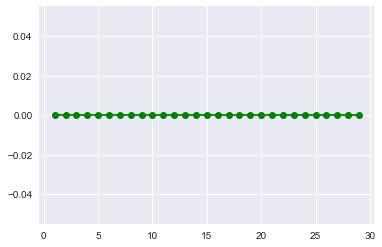

In [94]:
#生成初始化陣列，儲存模型預測分數的平均值和標準差
_mean = np.zeros(df.shape[1], dtype=np.int)
_std = np.zeros(df.shape[1], dtype=np.int)

clf = RandomForestClassifier(random_state = randomState)

for i in range(df.shape[1]):  #逐一加入變數，共計29個變數
    print(f'shape of x: {x[FI.feature[:i+1]].shape}', end = ' ')
    score = cross_val_score(clf, x[FI.feature[:i+1]], y, cv = 10, scoring = 'roc_auc')
    _mean[i] = score.mean()
    _std[i] = score.std()
    print(f'RF: {score.mean()} \u00B1 {score.std()}')
    
plt.plot(range(1, df.shape[1] + 1), _mean, color = 'g', marker = 'o')
plt.fill_between(range(1, df.shape[1] + 1), _mean + _std, _mean - _std, alpha = 0.15, color = 'green')
plt.show()

以上使用np.zeros出現錯誤問題，改用別的方式:

shape of x: (89, 1) RF: 0.625 ± 0.2654354816108035
shape of x: (89, 2) RF: 0.7642857142857142 ± 0.22753672051709248
shape of x: (89, 3) RF: 0.7910714285714285 ± 0.18088677538782122
shape of x: (89, 4) RF: 0.7839285714285713 ± 0.15072105604292282
shape of x: (89, 5) RF: 0.7901785714285714 ± 0.2156670507650955
shape of x: (89, 6) RF: 0.8285714285714285 ± 0.16850180160122072
shape of x: (89, 7) RF: 0.7928571428571429 ± 0.22163009263000294
shape of x: (89, 8) RF: 0.7928571428571429 ± 0.22857142857142856
shape of x: (89, 9) RF: 0.7678571428571429 ± 0.22502834288604806
shape of x: (89, 10) RF: 0.7714285714285715 ± 0.23471106858068222
shape of x: (89, 11) RF: 0.8178571428571428 ± 0.19672056219886302
shape of x: (89, 12) RF: 0.8160714285714287 ± 0.17570013009182925
shape of x: (89, 13) RF: 0.8160714285714287 ± 0.17570013009182925
shape of x: (89, 14) RF: 0.8267857142857142 ± 0.1694171430739727
shape of x: (89, 15) RF: 0.8196428571428571 ± 0.1709908847075224
shape of x: (89, 16) RF: 0.791964285

TypeError: unsupported operand type(s) for -: 'list' and 'list'

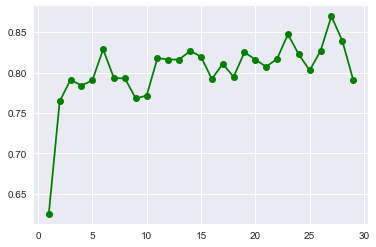

In [97]:
#生成初始化陣列，儲存模型預測分數的平均值和標準差
_mean = []
_std = []

clf = RandomForestClassifier(random_state = randomState)

for i in range(df.shape[1]):  #逐一加入變數，共計29個變數
    print(f'shape of x: {x[FI.feature[:i+1]].shape}', end = ' ')
    score = cross_val_score(clf, x[FI.feature[:i+1]], y, cv = 10, scoring = 'roc_auc')
    _mean.append(score.mean())
    _std.append(score.std())
    print(f'RF: {score.mean()} \u00B1 {score.std()}')
    
plt.plot(range(1, df.shape[1] + 1), _mean, color = 'g', marker = 'o')
plt.fill_between(range(1, df.shape[1] + 1), _mean + _std, _mean - _std, alpha = 0.15, color = 'green')
plt.show()

使用陣列方式生成_mean和_std，後續繪圖時也會產生錯誤，再調整方式:

shape of x: (108, 1) RF: 0.6544444444444445 ± 0.28865161195881056
shape of x: (108, 2) RF: 0.7166666666666667 ± 0.2908586691712983
shape of x: (108, 3) RF: 0.82 ± 0.18931650942466888
shape of x: (108, 4) RF: 0.8383333333333333 ± 0.13399027972852506
shape of x: (108, 5) RF: 0.8161111111111111 ± 0.16730341329083948
shape of x: (108, 6) RF: 0.7883333333333333 ± 0.2282576246478451
shape of x: (108, 7) RF: 0.7411111111111112 ± 0.27618655352076615
shape of x: (108, 8) RF: 0.7383333333333333 ± 0.24692491486329787
shape of x: (108, 9) RF: 0.793888888888889 ± 0.17875512597329452
shape of x: (108, 10) RF: 0.7538888888888889 ± 0.1923706876878114
shape of x: (108, 11) RF: 0.7911111111111112 ± 0.18052050941925588
shape of x: (108, 12) RF: 0.8016666666666665 ± 0.19659210764962934
shape of x: (108, 13) RF: 0.8311111111111111 ± 0.16663332999933317
shape of x: (108, 14) RF: 0.8472222222222221 ± 0.16358729311635364
shape of x: (108, 15) RF: 0.8277777777777778 ± 0.1998301748120941
shape of x: (108, 16) R

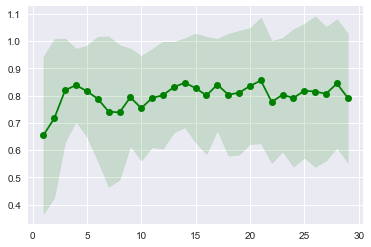

In [197]:
#生成初始化陣列，儲存模型預測分數的平均值和標準差
_mean = np.empty(df.shape[1])
_std = np.empty(df.shape[1])

clf = RandomForestClassifier(random_state = randomState)

for i in range(df.shape[1]):  #逐一加入變數，共計29個變數
    print(f'shape of x: {x[FI.feature[:i+1]].shape}', end = ' ')
    score = cross_val_score(clf, x[FI.feature[:i+1]], y, cv = 10, scoring = 'roc_auc')
    _mean[i] = score.mean()
    _std[i] = score.std()
    print(f'RF: {score.mean()} \u00B1 {score.std()}')
    
plt.plot(range(1, df.shape[1] + 1), _mean, color = 'g', marker = 'o')
plt.fill_between(range(1, df.shape[1] + 1), _mean + _std, _mean - _std, alpha = 0.15, color = 'green')
plt.show()

經觀察，發現模型在加入到第25個變數時，預測分數來到最大值

In [198]:
# 特徵篩選後的模型
x = df_train[FI.feature[:25]]
y = target
print(f'shape of x: {x.shape}')

model_selection(x, y, 10)

shape of x: (108, 25)
Naive Bayes: 0.8533333333333333 ± 0.17074997966487598
KNN: 0.6772222222222222 ± 0.21371854688807573
Logistic Regression: 0.8644444444444443 ± 0.17531629265169796
SVM: 0.861111111111111 ± 0.26068523188599846
Decision Tree: 0.6144444444444443 ± 0.18421002506197467
Random Forest: 0.8177777777777779 ± 0.24626594076373395
Gradient Boosting: 0.7961111111111111 ± 0.15315710484803535
XGBoost: 0.8100000000000002 ± 0.20174852945140012


選幾個比較強的模型，進行超參數調整:

In [199]:
#RANDOM FOREST
rfc_model = RandomForestClassifier(random_state = 42)
# USING GRID SEARCH
n_estimators = [100, 200, 300, 400]
max_depth = [1, 2, 3]
min_samples_leaf = [1, 2, 3]
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
grid_search_rfc = GridSearchCV(estimator = rfc_model, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
rfc_score = cross_val_score(grid_search_rfc.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('Random Forest Best Parmas',grid_search_rfc.best_params_)
print(f'Random Forest Best Score: {rfc_score.mean()} \u00B1 {rfc_score.std()}')

# GRADIENT BOOSTING
gdbt = GradientBoostingClassifier(random_state = 42)
# USING GRID SEARCH
learning_rate = [0.001, 0.01, 0.1, 1, 10]
n_estimators = [100, 200 ,300]
max_depth = [1, 2, 3, 4, 5]
param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth)
grid_search_gdbt = GridSearchCV(estimator = gdbt, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
gdbt_score = cross_val_score(grid_search_gdbt.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('GDBT Best Parmas',grid_search_gdbt.best_params_)
print(f'GDBT Best Score: {gdbt_score.mean()} \u00B1 {gdbt_score.std()}')

Random Forest Best Parmas {'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 200}
Random Forest Best Score: 0.8666666666666668 ± 0.21034950339909744
GDBT Best Parmas {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
GDBT Best Score: 0.7977777777777778 ± 0.17969796332928029


In [200]:
#測試資料
x_test = df_test[FI.feature[:25]]
print(x_test.shape)

(33, 25)


In [202]:
# random forest
rfc_model = grid_search_rfc.best_estimator_
rfc_model.fit(x, y)

rfc_pred = rfc_model.predict_proba(x_test)[:, 1]

sub = pd.DataFrame({'name':test_data['name'], 'poi':rfc_pred})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_rfc_top25_submission.csv', index = False)
sub.head()

,name,poi
0,BELDEN TIMOTHY N,0.201287
1,BOWEN JR RAYMOND M,0.186826
2,HANNON KEVIN P,0.285025
3,DELAINEY DAVID W,0.163236
4,CAUSEY RICHARD A,0.190860


![jupyter](./2022-06-25.png)

In [207]:
# gradient boosting tree
gdbt = grid_search_gdbt.best_estimator_
gdbt.fit(x, y)

gdbt_pred = gdbt.predict_proba(x_test)[:, 1]

sub = pd.DataFrame({'name':test_data['name'], 'poi':gdbt_pred})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_gdbt_top25_submission.csv', index = False)
sub.head()

,name,poi
0,BELDEN TIMOTHY N,0.000099
1,BOWEN JR RAYMOND M,0.999888
2,HANNON KEVIN P,0.998813
3,DELAINEY DAVID W,0.000157
4,CAUSEY RICHARD A,0.000010


![jupyter](./2022-06-25-2.png)

嘗試集成方法blending:

In [206]:
y_blend = 0.6 * gdbt_pred + 0.4 * rfc_pred
sub = pd.DataFrame({'name':test_data['name'], 'poi':y_blend})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_gdbt_rf_top25_blending_submission.csv', index = False)
sub.head()

,name,poi
0,BELDEN TIMOTHY N,0.080574
1,BOWEN JR RAYMOND M,0.674663
2,HANNON KEVIN P,0.713298
3,DELAINEY DAVID W,0.065388
4,CAUSEY RICHARD A,0.076350


![jupyter](./2022-06-26.png)

Blending後的結果反而比使用單一模型要差一些

加上特徵工程方法優化:使用葉編碼

[參考](https://www.cupoy.com/marathon-mission/0000017705894B9C000000036375706F795F72656C656173654355/00000177151DD99B000000206375706F795F70726572656C656173654349/)

樹狀模型 做出預測時，模型預測時就會將資料重新分成好幾個區塊，也就是決策樹的 葉點 (決策樹最末端的點，詳見下頁) ，每個葉點的資料性質接近，可視為資料的一種分組方式

雖然不適合直接沿用樹狀模型機率，但分組方式有代表性，因此按照葉點將資料 離散化 ，比之前提過的離散化方式更精確，這樣的編碼我們就稱為葉編碼

In [208]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
onehot = OneHotEncoder() 
lr = LogisticRegression()
lr.fit(onehot.fit_transform(rfc_model.apply(x)), y) # 將訓練過的隨機森林特徵做獨熱編碼，再丟進模型裡訓練

pred_rf_lr = lr.predict_proba(onehot.transform(rfc_model.apply(x_test)))[:, 1] # 只取生存下來的機率 :1

sub = pd.DataFrame({'name':test_data['name'], 'poi':pred_rf_lr})
sub.at[20, 'poi'] = 0 # 更正錯誤值

sub.to_csv('enron_gdbt_rf_leaf.csv', index = False)
sub.head()

,name,poi
0,BELDEN TIMOTHY N,0.811312
1,BOWEN JR RAYMOND M,0.256538
2,HANNON KEVIN P,0.996078
3,DELAINEY DAVID W,0.574738
4,CAUSEY RICHARD A,0.099395


![jupyter](./2022-06-26-2.png)

葉編碼處理之後分數大幅提升

再做一次特徵工程:嘗試平衡資料標籤 [參考](https://taweihuang.hpd.io/2018/12/30/imbalanced-data-sampling-techniques/)

透過 SMOTE(Synthetic Minority Oversampling Technique)技術，將不平衡的 POI Label 調整為 True :Fales = 1:1 

In [212]:
# SMOTE

sm = SMOTE(random_state = 42)
train_data_res,train_Y_res = sm.fit_resample(df_train, target)
train_data_res = pd.DataFrame(train_data_res, columns = df.columns)

x = train_data_res
y = train_Y_res
print(f'x shape: {x.shape}')

model_selection(x, y, 10)

x shape: (190, 29)
Naive Bayes: 0.915 ± 0.05795112883571237
KNN: 0.9133333333333333 ± 0.07282653159188418
Logistic Regression: 0.9366666666666668 ± 0.07045706161105637
SVM: 0.9811111111111112 ± 0.02813108644704926
Decision Tree: 0.8822222222222221 ± 0.06753142844010107
Random Forest: 0.9955555555555555 ± 0.010183501544346305
Gradient Boosting: 0.9800000000000001 ± 0.030143688813890082
XGBoost: 0.9933333333333334 ± 0.014229164972072977


In [213]:
# 測試特徵重要性
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = randomState)

gdbt_model = RandomForestClassifier(n_estimators = 100, random_state = randomState)
gdbt_model.fit(x_train, y_train)
FI = pd.DataFrame({'feature':x.columns, 'importance':gdbt_model.feature_importances_}).sort_values(by = 'importance', ascending = False)
FI

,feature,importance
6,expenses,0.147963
5,other,0.133321
25,to_poi_ratio,0.085511
28,total_value,0.063685
15,total_stock_value,0.051182
13,restricted_stock,0.048157
9,bonus_payment_ratio,0.048151
22,from_this_person_to_poi,0.043258
11,bonus_salary_ratio,0.037634
19,from_messages,0.035640


shape of x: (190, 1) RF: 0.8333333333333333 ± 0.07710022337480252
shape of x: (190, 2) RF: 0.9400000000000001 ± 0.03386611256472928
shape of x: (190, 3) RF: 0.9722222222222223 ± 0.04194352464039303
shape of x: (190, 4) RF: 0.9744444444444446 ± 0.04501028689006465
shape of x: (190, 5) RF: 0.9788888888888889 ± 0.03725123247608935
shape of x: (190, 6) RF: 0.9788888888888888 ± 0.03303570832737448
shape of x: (190, 7) RF: 0.986111111111111 ± 0.028246052930858138
shape of x: (190, 8) RF: 0.9872222222222222 ± 0.023837153281027704
shape of x: (190, 9) RF: 0.9799999999999999 ± 0.031348302177035325
shape of x: (190, 10) RF: 0.9855555555555556 ± 0.02182986967154277
shape of x: (190, 11) RF: 0.9833333333333332 ± 0.02533723166886973
shape of x: (190, 12) RF: 0.9844444444444445 ± 0.02287917809108222
shape of x: (190, 13) RF: 0.9922222222222222 ± 0.011166528467912076
shape of x: (190, 14) RF: 0.9944444444444445 ± 0.011385500851066224
shape of x: (190, 15) RF: 0.9966666666666667 ± 0.007114582486036503

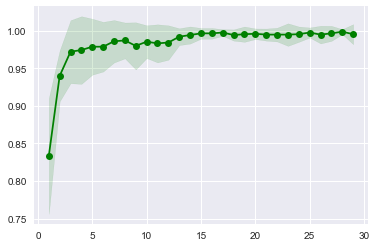

In [214]:
_mean = np.empty(df.shape[1])
_std = np.empty(df.shape[1])
clf = RandomForestClassifier(random_state = randomState)

for i in range(df.shape[1]):
    print(f'shape of x: {x[FI.feature[:i+1]].shape}', end = ' ')
    score = cross_val_score(clf, x[FI.feature[:i+1]], y, cv = 10, scoring = 'roc_auc')
    _mean[i] = score.mean()
    _std[i] = score.std()
    print(f'RF: {score.mean()} \u00B1 {score.std()}')
plt.plot(range(1, df.shape[1] + 1), _mean, color = 'g', marker = 'o')
plt.fill_between(range(1, df.shape[1] + 1), _mean + _std, _mean - _std, alpha = 0.15, color = 'green')
plt.show()

目前觀察，選前 28 名的特徵有最好的結果

In [215]:
# smote
x = train_data_res[FI.feature[:28]]
y = train_Y_res
print(f'shape of x: {x.shape}')

model_selection(x, y, 10)

shape of x: (190, 28)
Naive Bayes: 0.9144444444444444 ± 0.05817173383425963
KNN: 0.9133333333333333 ± 0.07282653159188418
Logistic Regression: 0.9366666666666668 ± 0.07045706161105637
SVM: 0.9822222222222223 ± 0.028196838978776714
Decision Tree: 0.8727777777777778 ± 0.0723695079367847
Random Forest: 0.9988888888888889 ± 0.0033333333333333214
Gradient Boosting: 0.9811111111111112 ± 0.030245905752924886
XGBoost: 0.9911111111111112 ± 0.017069212773041353


In [216]:
# 選幾個比較強的模型

#RANDOM FOREST
rfc_model = RandomForestClassifier(random_state = 42)
# USING GRID SEARCH
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800]
max_depth = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3]
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
grid_search_rfc = GridSearchCV(estimator = rfc_model, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
rfc_score = cross_val_score(grid_search_rfc.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('Random Forest Best Parmas',grid_search_rfc.best_params_)
print(f'Random Forest Best Score: {rfc_score.mean()} \u00B1 {rfc_score.std()}')

# GRADIENT BOOSTING
gdbt = GradientBoostingClassifier(random_state = 42)
# USING GRID SEARCH
learning_rate = [0.001, 0.01, 0.1, 1, 10]
n_estimators = [100, 200 ,300]
max_depth = [1, 2, 3, 4, 5]
param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth)
grid_search_gdbt = GridSearchCV(estimator = gdbt, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
gdbt_score = cross_val_score(grid_search_gdbt.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('GDBT Best Parmas',grid_search_gdbt.best_params_)
print(f'GDBT Best Score: {gdbt_score.mean()} \u00B1 {gdbt_score.std()}')

Random Forest Best Parmas {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Random Forest Best Score: 0.9966666666666667 ± 0.007114582486036486
GDBT Best Parmas {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 100}
GDBT Best Score: 0.9911111111111112 ± 0.023200681130912348


In [217]:
x_test = df_test[FI.feature[:28]]
print(x_test.shape)

(33, 28)


In [219]:
# random forest

rfc_model = grid_search_rfc.best_estimator_
rfc_model.fit(x, y)
rfc_pred_sm = rfc_model.predict_proba(x_test)[:, 1]
sub = pd.DataFrame({'name':test_data['name'], 'poi':rfc_pred_sm})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_rfc__top28_smote_submission.csv', index = False)
sub.head()

,name,poi
0,BELDEN TIMOTHY N,0.372975
1,BOWEN JR RAYMOND M,0.846068
2,HANNON KEVIN P,0.815117
3,DELAINEY DAVID W,0.372936
4,CAUSEY RICHARD A,0.966060


![jupyter](./2022-06-26-3.png)

In [220]:
# gradient boosting tree

gdbt = grid_search_gdbt.best_estimator_
gdbt.fit(x, y)
gdbt_pred_sm = gdbt.predict_proba(x_test)[:, 1]
sub = pd.DataFrame({'name':test_data['name'], 'poi':gdbt_pred_sm})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_gdbt__top28_smote_submission.csv', index = False)
sub.head()

,name,poi
0,BELDEN TIMOTHY N,0.032898
1,BOWEN JR RAYMOND M,1.000000
2,HANNON KEVIN P,0.678928
3,DELAINEY DAVID W,0.570337
4,CAUSEY RICHARD A,1.000000


![jupyter](./2022-06-26-4.png)

In [223]:
# blending

y_blend_sm = 0.6 * gdbt_pred_sm + 0.4 * rfc_pred_sm
sub = pd.DataFrame({'name':test_data['name'], 'poi':y_blend_sm})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_gdbt_rf_top28_smote_blending.csv', index = False)
sub.head()

,name,poi
0,BELDEN TIMOTHY N,0.168929
1,BOWEN JR RAYMOND M,0.938427
2,HANNON KEVIN P,0.733404
3,DELAINEY DAVID W,0.491377
4,CAUSEY RICHARD A,0.986424


![jupyter](./2022-06-26-5.png)

In [224]:
# leaf encoding

onehot = OneHotEncoder()
onehot.fit(rfc_model.apply(x)) # 將訓練過的隨機森林特徵做獨熱編碼

lr = LogisticRegression(random_state = randomState)
lr.fit(onehot.transform(rfc_model.apply(x)), y) # 再用另一筆訓練資料代入隨機森林模型得到分類別，
                                                 # 以獨熱編碼轉換後，用以訓練邏輯迴歸模型

pred_rf_lr_sm = lr.predict_proba(onehot.transform(rfc_model.apply(x_test)))[:, 1] # 只取生存下來的機率 :1

sub = pd.DataFrame({'name':test_data['name'], 'poi':pred_rf_lr_sm})
sub.at[20, 'poi'] = 0 # 更正錯誤值

sub.to_csv('enron_gdbt_rf_top28_smote_blending_leaf.csv', index = False)
sub.head()

,name,poi
0,BELDEN TIMOTHY N,0.219694
1,BOWEN JR RAYMOND M,0.991010
2,HANNON KEVIN P,0.979694
3,DELAINEY DAVID W,0.154357
4,CAUSEY RICHARD A,0.999568


![jupyter](./2022-06-26-6.png)